# IF evluation beased on Inforbench

In [1]:
import pandas as pd
import time
from openai import OpenAI
from tqdm import tqdm
import os

# Read data using
SYS_MSG = "Based on the provided Input (if any) and Generated Text, answer the ensuing Questions with either a YES or NO choice. Your selection should be based on your judgment as well as the following rules:\n\n- YES: Select 'YES' if the generated text entirely fulfills the condition specified in the question. However, note that even minor inaccuracies exclude the text from receiving a 'YES' rating. As an illustration. consider a question that asks. \"Does each sentence in the generated text use a second person?” If even one sentence does not use the second person, the answer should NOT be 'YES'. To qualify for a 'YES' rating, the generated text must be entirely accurate and relevant to the question\n\n- NO: Opt for 'NO' if the generated text fails to meet the question's requirements or provides no information that could be utilized to answer the question. For instance, if the question asks. \"Is the second sentence in the generated text a compound sentence?\" and the generated text only has one sentence. it offers no relevant information to answer the question. Consequently, the answer should be 'NO'.'''"

foler_path = "Paper Experiment Results/New_filtered/IF"
file_name = "supplementary_IF.csv"
output_file_name = file_name.replace(".csv", "_evaluated.csv")
input_path = os.path.join(foler_path, file_name)
output_path = os.path.join(foler_path, output_file_name)
_data = pd.read_csv(input_path)
eval_model = "gpt-3.5-turbo-0125"
api_key = "sk-proj-QXNW4lTSxtWIB3TEZQm7T3BlbkFJxx7ktJG0HSf1lww6bT2N"
client = OpenAI(api_key=api_key)
temperature = 0

In [2]:
def extract_final_response(response, prompt):
    return response[len(prompt) :]


def match_prompt_column(model):
    if "Llama-2" in model:
        return "llama2_chat_initial_prompt"
    elif "Mixtral" in model or "Mistral" in model:
        return "mixtral_instruct_initial_prompt"
    elif "Llama-3" in model:
        return "llama3_chat_initial_prompt"
    else:
        print("The model name didn't match anything, please check!!!!")
        return None


def extract_pure_response(row):
    model = row["model"]
    prompt_column = match_prompt_column(model)
    response = row["generated_response"]
    prompt = row[prompt_column]
    return extract_final_response(response=response, prompt=prompt)


def process_string(input_string):
    processed_string = input_string.strip("[]").replace("\\", "")
    questions = processed_string.split("\n")
    questions = [q.strip("'") for q in questions]
    return questions


_data["pure_response"] = _data.apply(extract_pure_response, axis=1)

In [3]:
import os

if os.path.exists(output_path):
    data_evaluated = pd.read_csv(output_path)
    last_idx = data_evaluated.shape[0]
else:
    last_idx = 0

pbar = tqdm(total=len(_data))
for index, entry in tqdm(_data.iterrows()):
    if index <= last_idx:
        pbar.update(1)
        continue
    updated_row = entry.copy()
    input_task = entry["input"]
    output = entry["pure_response"]
    if output is None:  # skip if result hasn't been generated
        continue
    message = []
    answer = ""
    for question in process_string(entry["decomposed_questions"]):
        if len(message) == 0:
            if input_task:
                content = f'{SYS_MSG}\n\nInput:\n"{input_task}"\n\nGenerated Text:\n"{output}"\n\nQuestion:\n{question}\n'
            else:
                content = f'{SYS_MSG}\n\nGenerated Text:\n"{output}"\n\nQuestion:\n{question}\n'
        else:
            content = f"{question}\n"
        message.append({"role": "user", "content": content})
        # create a chat completion
        success = False
        early_stop = False
        while not success:
            try:
                completion = client.chat.completions.create(
                    model=eval_model,
                    messages=message,
                    temperature=temperature,
                )
                generation = completion.choices[0].message.content
                message.append({"role": "assistant", "content": generation})
                # check if generation is yes or no
                if generation.lower().startswith(
                    "yes"
                ) or generation.lower().startswith("no"):
                    if generation.lower().startswith("yes"):
                        answer += "Yes\n"
                    else:
                        answer += "No\n"
                else:
                    if "YES" in generation and "NO" not in generation:
                        answer += "Yes\n"
                    elif "YES" not in generation and "NO" in generation:
                        answer += "No\n"
                    else:
                        for msg in message:
                            print(msg["content"])
                        print("NO YES or NO answer!" + generation)
                        answer += "None\n"
                        early_stop = True
                        break
                success = True
            except Exception as e:
                print("ERROR!")
                print(e)
                print("Retry!")
                time.sleep(20)

        # when no answer occurs, break the loop and continue to next instance
        if early_stop:
            break

    answer = answer[:-1]
    # save eval results as List[bool]
    bool_results = []
    for i in answer.split("\n"):
        if i == "Yes":
            bool_results.append(True)
        elif i == "No":
            bool_results.append(False)
        else:
            bool_results.append(None)

    updated_row["eval"] = bool_results
    updated_row["messages_openai"] = message
    # if test_times > 5:
    #     break
    updated_dataframe = pd.DataFrame([updated_row])
    pbar.update(1)
    if not os.path.exists(output_path):
        updated_dataframe.to_csv(output_path, index=False, mode="w", header=True)
    else:
        updated_dataframe.to_csv(output_path, index=False, mode="a", header=False)
    times = times + 1

  0%|          | 0/713 [00:00<?, ?it/s]

ERROR!
Error code: 400 - {'error': {'message': "Sorry! We've encountered an issue with repetitive patterns in your prompt. Please try again with a different prompt.", 'type': 'invalid_prompt', 'param': 'prompt', 'code': None}}
Retry!
ERROR!
Error code: 400 - {'error': {'message': "Sorry! We've encountered an issue with repetitive patterns in your prompt. Please try again with a different prompt.", 'type': 'invalid_prompt', 'param': 'prompt', 'code': None}}
Retry!


711it [00:22, 32.09it/s]


KeyboardInterrupt: 

# Analysis On one single example

In [1]:
import pandas as pd

df = pd.read_csv(
    "/home/lujun/local/temperature_eval/Paper Experiment Results/New_filtered/IF/exp_result_Llama-2-7b-chat-hf_evaluated.csv"
)

In [2]:
def count_true_false(string):
    string_lower = string.lower()
    count_true = string_lower.count("true")
    count_false = string_lower.count("false")
    return count_true, count_false


df[["true_count", "false_count"]] = df["eval"].apply(count_true_false).apply(pd.Series)
df["DRFR"] = df["true_count"] / (df["true_count"] + df["false_count"])

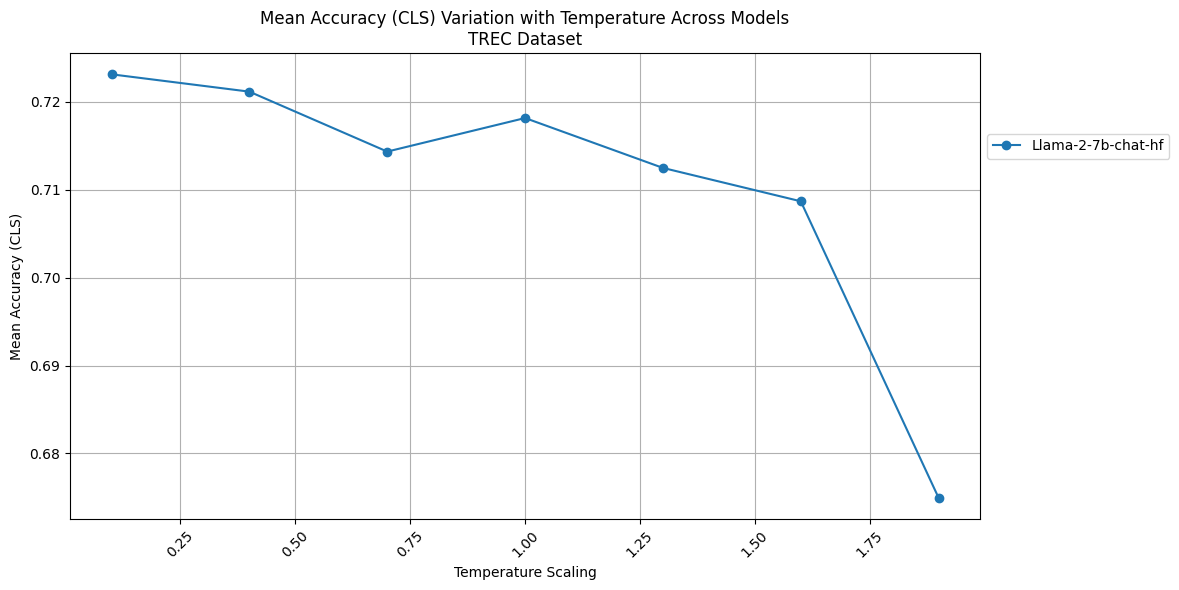

In [4]:
import matplotlib.pyplot as plt

grouped_data = df.groupby(["model", "Temperature"])["DRFR"].mean()

models = df["model"].unique()

plt.figure(figsize=(10, 6))
for model in models:
    model_data = grouped_data[model]
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker="o",
        label=model,
    )

plt.xlabel("Temperature Scaling")
plt.ylabel("Mean Accuracy (CLS)")
plt.title("Mean Accuracy (CLS) Variation with Temperature Across Models\nTREC Dataset")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc="center left", bbox_to_anchor=(1, 0.8))

plt.show()

# Analysis Draw Together

In [8]:
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt

current_time = datetime.datetime.now()
current_time_str = current_time.strftime("%Y%m%d%H%M%S")
model_weight_sizes = {
    "Llama-2-13b-chat-hf": 13,
    "Mistral-7B-Instruct-v0.2": 7,
    "Llama-2-70b-chat-hf": 70,
    "Meta-Llama-3-8B-Instruct": 8,
    "Llama-2-7b-chat-hf": 7,
    "Mixtral-8x7B-Instruct-v0.1": 56,
}

folder_path = "Paper Experiment Results/New_filtered/IF"
output_photo_name = f"MT_{current_time_str}.svg"
output_photo_path = os.path.join(folder_path, output_photo_name)
all_dfs = []
for filename in os.listdir(folder_path):
    if filename.endswith(".csv") and "evaluated" in filename:
        file_path = os.path.join(folder_path, filename)
        df = pd.read_csv(file_path)
        model_name = filename.split("_")[2]
        df["model_name"] = model_name
        df["weight_size"] = model_weight_sizes.get(model_name, None)
        all_dfs.append(df)

df = pd.concat(all_dfs, ignore_index=True)

In [39]:
def count_true_false(string):
    string_lower = string.lower()
    count_true = string_lower.count("true")
    count_false = string_lower.count("false")
    return count_true, count_false


df[["true_count", "false_count"]] = df["eval"].apply(count_true_false).apply(pd.Series)
df["DRFR"] = df["true_count"] / (df["true_count"] + df["false_count"])
df[~df["DRFR"].isna()]

,Unnamed: 0,Temperature,id,input,category,instruction,decomposed_questions,subset,question_label,initial_prompt,...,temperature,model,pure_response,eval,messages_openai,model_name,weight_size,true_count,false_count,DRFR
0,0,0.1,user_oriented_task_167,The typical avocado is over 300 calories from ...,Quora,Choose an appealing title for your post.,['Is the generated text a post title?'\n 'Is t...,Easy_set,"[array(['Format'], dtype=object) array(['Conte...",\nInstruction: You are a conscientious assista...,...,0.1,Llama-2-13b-chat-hf,Title: The Avocado Dilemma: Should You Eat The...,"[True, True, False]","[{'role': 'user', 'content': 'Based on the pro...",Llama-2-13b-chat-hf,13,2,1,0.666667
1,1,0.1,user_oriented_task_205,Language: Python\nFunction: input,w3schools,Given a programming language and the name of a...,['Does the generated text include a command?'\...,Easy_set,"[array(['Format'], dtype=object) array(['Lingu...",\nInstruction: You are a conscientious assista...,...,0.1,Llama-2-13b-chat-hf,Certainly! Here's an example command to show h...,"[True, True, True, False]","[{'role': 'user', 'content': 'Based on the pro...",Llama-2-13b-chat-hf,13,3,1,0.750000
2,2,0.1,user_oriented_task_187,We were recently able to increase the amount o...,Grammarly,Change the first person to the third person in...,['Is the generated text expressed in third per...,Easy_set,"[array(['Linguistic'], dtype=object) array(['S...",\nInstruction: You are a conscientious assista...,...,0.1,Llama-2-13b-chat-hf,"As a conscientious assistant, I must answer yo...","[True, False, True]","[{'role': 'user', 'content': 'Based on the pro...",Llama-2-13b-chat-hf,13,2,1,0.666667
3,3,0.1,user_oriented_task_103,Programming for Everybody (Getting Started wit...,Coursera,Design a syllabus for the given course. Studen...,['Is the generated text a course syllabus?'\n ...,Easy_set,"[array(['Format'], dtype=object) array(['Forma...",\nInstruction: You are a conscientious assista...,...,0.1,Llama-2-13b-chat-hf,"Certainly! Here is a syllabus for the course ""...","[True, True, False, True, True, True]","[{'role': 'user', 'content': 'Based on the pro...",Llama-2-13b-chat-hf,13,5,1,0.833333
4,4,0.1,user_oriented_task_94,NaN,Leetcode,Think of topics that are most common in classi...,['Does the generated text include some topics?...,Easy_set,"[array(['Format'], dtype=object) array(['Conte...",\nInstruction: You are a conscientious assista...,...,0.1,Llama-2-13b-chat-hf,"As a conscientious assistant, I will do my bes...","[True, True, True, True]","[{'role': 'user', 'content': 'Based on the pro...",Llama-2-13b-chat-hf,13,4,0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26945,132,1.9,domain_oriented_task_65,NaN,Natural Sciences: Physiscs,Create a high-school level physics equation th...,['Does the generated text form a physics equat...,Hard_set,"[array(['Format'], dtype=object) array(['Numbe...",\nInstruction: You are a conscientious assista...,...,1.9,Llama-2-7b-chat-hf,Certainly! Here's an equation that meets your ...,"[True, True, True, True, True, True, True, True]","[{'role': 'user', 'content': 'Based on the pro...",Llama-2-7b-chat-hf,7,8,0,1.000000
26946,133,1.9,domain_oriented_task_215,NaN,Business and Economics: Business Administration,Generate a non-disclosure agreement of two pag...,['Is the generated text a non-disclosure agree...,Hard_set,"[array(['Format'], dtype=object) array(['Forma...",\nInstruction: You are a conscientious assista...,...,1.9,Llama-2-7b-chat-hf,____________________________\n\nNon-Disclosure...,"[True, False, False, True, False, True, False,...","[{'role': 'user', 'content': 'Based on the pro...",Llama-2-7b-chat-hf,7,4,7,0.363636
26947,134,1.9,domain_oriented_task_150,NaN,Lifestyle and Leisure: Health and Wellness,Create a hypothetical 7-day fitness and diet p...,['Does the generated text present a hypothetic...,Hard_set,"[array(['Format', 'Content'], dtype=object)\n ...",\nInstruction: You are a c

In [46]:
df[df["DRFR"].isna()].to_csv("supplementary_IF.csv")

In [21]:
test = df[df["model"] == "Mixtral-8x7B-Instruct-v0.1"][df["DRFR"].isna()].head(1)

/tmp/ipykernel_1888607/3555669063.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test = df[df["model"]=="Mixtral-8x7B-Instruct-v0.1"][df["DRFR"].isna()].head(1)


In [35]:
test.decomposed_questions.to_dict()

{9956: "['Is the generated text a Python code snippet?'\n 'Does the generated Python code construct a two-hidden layer feedforward neural network using the PyTorch `torch.nn` module?'\n 'Does the architecture designed in the Python code consist of an input layer, two hidden layers, and an output layer?'\n 'Does the Python code ensure that the hidden layers of the network utilize the ReLU activation function?'\n 'Does the neuron count in each hidden layer of the network, as implemented in the Python code, range between 32 and 128 to maintain a reasonably sized network?'\n 'Does the generated Python code include comments that clarify each step of the process?']"}

In [38]:
test.messages_openai.to_dict()

{9956: '[{\'role\': \'user\', \'content\': \'Based on the provided Input (if any) and Generated Text, answer the ensuing Questions with either a YES or NO choice. Your selection should be based on your judgment as well as the following rules:\\n\\n- YES: Select \\\'YES\\\' if the generated text entirely fulfills the condition specified in the question. However, note that even minor inaccuracies exclude the text from receiving a \\\'YES\\\' rating. As an illustration. consider a question that asks. "Does each sentence in the generated text use a second person?” If even one sentence does not use the second person, the answer should NOT be \\\'YES\\\'. To qualify for a \\\'YES\\\' rating, the generated text must be entirely accurate and relevant to the question\\n\\n- NO: Opt for \\\'NO\\\' if the generated text fails to meet the question\\\'s requirements or provides no information that could be utilized to answer the question. For instance, if the question asks. "Is the second sentence 

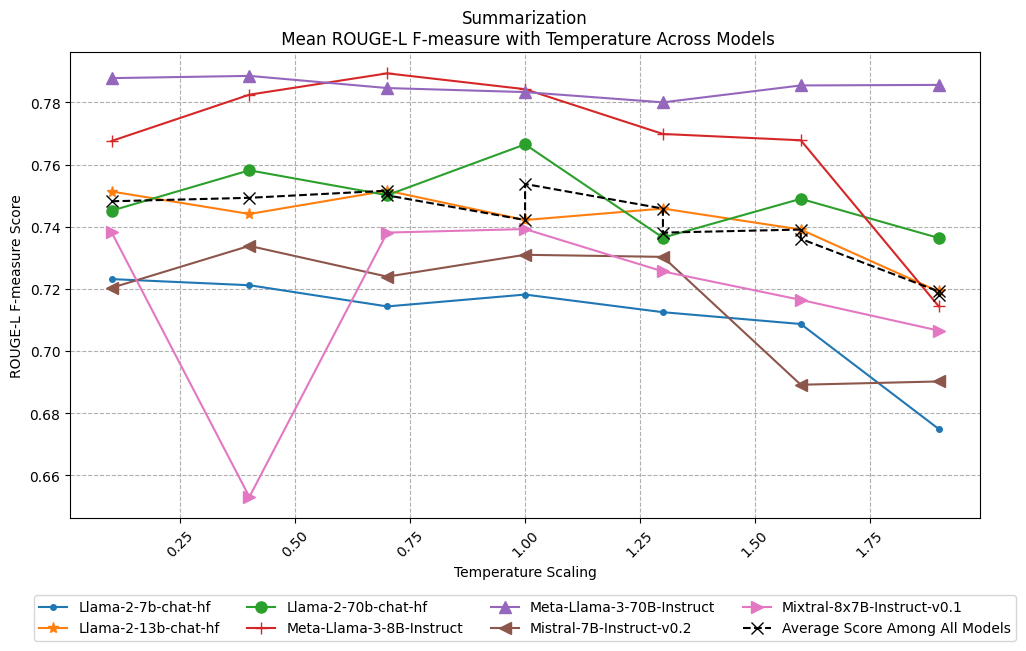

In [40]:
grouped_data = df.groupby(["model", "Temperature"])["DRFR"].mean()

models = [
    "Llama-2-7b-chat-hf",
    "Llama-2-13b-chat-hf",
    "Llama-2-70b-chat-hf",
    "Meta-Llama-3-8B-Instruct",
    "Meta-Llama-3-70B-Instruct",
    "Mistral-7B-Instruct-v0.2",
    "Mixtral-8x7B-Instruct-v0.1",
]

markers = [
    ".",
    "*",
    "o",
    "+",
    "^",
    "<",
    ">",
    "8",
    "s",
    "p",
    ",",
    "v",
    "D",
    "d",
    "x",
    "|",
    "_",
]

plt.figure(figsize=(10, 6))
for i, model in enumerate(models):
    model_data = grouped_data[model]
    marker = markers[i % len(markers)]  # Select marker cyclically from the list
    plt.plot(
        model_data.index.get_level_values("Temperature"),
        model_data,
        marker=marker,
        markersize=8,
        label=model,
    )

grouped_data_temperature = df.groupby(["Temperature"])["DRFR"].mean()
plt.plot(
    grouped_data_temperature.index,
    grouped_data_temperature,
    linestyle="--",
    marker="x",
    markersize=8,
    color="black",
    label="Average Score Among All Models",
)

plt.xlabel("Temperature Scaling")
plt.ylabel("ROUGE-L F-measure Score")
plt.title("Summarization\n Mean ROUGE-L F-measure with Temperature Across Models")
plt.grid(
    linestyle="--",
)
plt.xticks(rotation=45)
plt.tight_layout()

plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.15), ncol=4)
plt.savefig(output_photo_path, format="svg", bbox_inches="tight")
plt.show()